# Download required data directly from  NSIDC

## Set up local / personal environment

In [55]:
# Import dependancies

from earthdata import Auth, DataCollections, DataGranules, Store # Used to ingest data from NSIDC
import geopandas as gpd # Used to subset regions using shapefile
import rioxarray as rx # Used to read raster data from hdf5 files


In [4]:
# Set working directories (local)

data_loc = "/home/jovyan/data/"

In [5]:
# Authenticate Earthdata credentials

auth = Auth().login(strategy='netrc')
if auth.authenticated is False:
    auth = Auth().login(strategy='interactive')

You're now authenticated with NASA Earthdata Login


# Step 3 - Import MEaSUREs BedMachine Data from NSIDC

In [ ]:
# Identify data collections available based on keyword (here, use "bed topography" to identify collections with bed topography (e.g., BedMachine)
Query = DataCollections().keyword('bed topography').provider("NSIDC_ECS")

print(f'Collections found: {Query.hits()}')

In [ ]:
# Review the shortName and Abstract for all collections in order to identify the best dataset to use.
collections = Query.fields(['ShortName','Abstract']).get()
print(collections)

In [48]:
# For MEaSUREs BedMachine data, concept-id: C1664160168-NSIDC_ECS
bedmachine = 'C1664160168-NSIDC_ECS'

# TODO: Define a bounding box from a IMBIE / MEaSUREs boundary
# Query = DataGranules().concept_id(bedmachine).bounding_box(-134.7,58.9,-133.9,59.2)

# For testing, download without a bounding box
Query = DataGranules().concept_id(bedmachine)

print(f'Granules found: {Query.hits()}')

TypeError: bounding_box() missing 3 required positional arguments: 'lower_left_lat', 'upper_right_lon', and 'upper_right_lat'

In [ ]:
# Get the relevant granules for the collectin
granules = Query.get()
print(granules)

In [ ]:
# Download the data! 

# How long does this take?
#%%time

# Access the data from on-prem at NSIDC. Store this at "data_loc" locally.
access = Store(auth)
files = access.get(granules, local_path = data_loc)

# Step 1 - Import MEaSUREs Boundaries from NSIDC

In [ ]:
# Identify data collections available based on keyword (here, use "bed topography" to identify collections with bed topography (e.g., BedMachine)
Query = DataCollections().keyword('boundaries').provider("NSIDC_ECS")

print(f'Collections found: {Query.hits()}')

In [ ]:
# Review the shortName and Abstract for all collections in order to identify the best dataset to use.
collections = Query.fields(['ShortName','Abstract']).get()
print(collections)

In [ ]:
# For MEaSUREs boundaries, concept-id: C1454773262-NSIDC_ECS
boundaries = 'C1454773262-NSIDC_ECS'

# TODO: Define a bounding box from a IMBIE / MEaSUREs boundary
# Query = DataGranules().concept_id(bedmachine).bounding_box(-134.7,58.9,-133.9,59.2)

# For testing, download without a bounding box
Query = DataGranules().concept_id(boundaries)

print(f'Granules found: {Query.hits()}')

NameError: name 'bedmachine' is not defined

In [ ]:
# Get the relevant granules for the collectin
granules = Query.get()
print(granules)

# NOTE: The following datasets are contained here:
# - "Mask_Antarctica_v02" is the 1st element
# - "Basins_IMBIE_Antarctica_v02" is the 2nd element
# - "IceBoundaries_Antarctica_v02" is the 3rd element
# - "GroundingLine_Antarctica_v02" is the 4th element
# - "Basins_Antarctica_v02" is the 5th element
# - "IceShelf_Antarctica_v02" is the 6th element
# - "Coastline_Antarctica_v02" is the 7th element

In [ ]:
## NOTE - Thi Cell does not currently behave as expected. This returns the first file in each granule.
## Work-around provided in following cell, using wget to download each file from data_links()

# TODO: How do I download only one granuale from the list?
# TODO: Confirm how to download multiple files within a given granule. The below code only returns the first element/file from each granule. It does not return all files/elements associated with the shapefile.

# Access the data from on-prem at NSIDC. Store this at "data_loc" locally.
# access = Store(auth)
# files = access.get(granules, local_path = data_loc+"boundaries/")

In [ ]:
# Create a list of links to individual data files from each granule
data_links = [granule.data_links() for granule in granules]

# Loop over the list of data links for each granule - for each file, wget the file.
# TODO: How to feed "data_loc" (or other) directly into the wget command rather than hardcoding this directory here?
for i in data_links:
    tmp = i
    for j in tmp:
        #print(j)
        ! wget -nc {j} -P /home/jovyan/data/boundaries

# Step 2 - Subset the Antarctica Ice Boundaries for a given region [Totten Basin]

In [7]:
bd = gpd.read_file(data_loc+"/boundaries/IceBoundaries_Antarctica_v02.shp")

0    POLYGON ((-1604213.024 911528.811, -1603107.44...
1    POLYGON ((-680809.736 1356261.688, -680579.602...
2    POLYGON ((-650479.108 590441.379, -644265.131 ...
3    POLYGON ((-549906.633 1305863.952, -572323.238...
4    POLYGON ((-418449.622 1964493.872, -417441.371...
Name: geometry, dtype: geometry


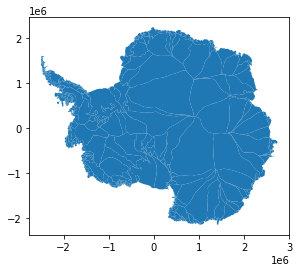

In [31]:
# Plot shapefile to make sure it as expected
bd.plot()

# 'Geometry' can be extracted - here, we print out the head of the geometry field
print(bd['geometry'].head())

,NAME,Regions,Subregions,TYPE,Asso_Shelf,geometry
40,Totten,East,Cp-D,GR,Totten,"POLYGON ((2239414.251 -1154868.625, 2238375.56..."


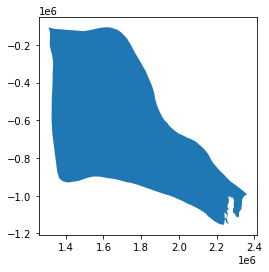

In [32]:
# Isolated only grounded ice (GR) for the Totten basin
tot = bd[(bd["NAME"] == "Totten") & (bd["TYPE"] == "GR")]

# Plot the Totten subset
tot.plot()

# View tot to make sure it is as expected
tot

In [53]:
# Identify the bounding box for the given region: total_bounds = total bounding box of all polygons (if multiple); bounds = bounding box for each polygon (if multiple).
# When only one polygon (in this case), .total_bounds, or .bounds are comparable
bbox = tot.total_bounds
bbox

array([ 1309143.63239696, -1154868.6246857 ,  2362495.34415517,
        -107085.52740615])

# Step 4 - Read-in raster files and subset to given region

In [61]:
ds=rx.open_rasterio(data_loc+"BedMachineAntarctica_2019-11-05_v01.nc", variable = "bed")
ds

<xarray.Dataset>
Dimensions:  (band: 1, x: 13333, y: 13333)
Coordinates:
  * band     (band) int64 1
  * x        (x) float64 -3.333e+06 -3.332e+06 ... 3.332e+06 3.333e+06
  * y        (y) float64 3.333e+06 3.332e+06 3.332e+06 ... -3.332e+06 -3.333e+06
    mapping  int64 0
Data variables:
    bed      (band, y, x) float32 ...
Attributes: (12/17)
    Author:                      Mathieu Morlighem
    Conventions:                 CF-1.7
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    ice_density (kg m-3):        917
    license:                     No restrictions on access or use
    Notes:                       Data processed at the Department of Earth Sy...
    ...                          ...
    sea_water_density (kg m-3):  1027
    spacing:                     500
    Title:                       BedMachine Antarctica
    version:                     05-Nov-2019 (v1.38)
    xmin:                        -3333000
    ymax:                        3333000

In [40]:
tot.total_bounds

array([ 1309143.63239696, -1154868.6246857 ,  2362495.34415517,
        -107085.52740615])